# Apparel Recommendation System 

This notebook has the models that I have tried for my recommendation Process

### Data Imports 

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

### Load Data Files

In [2]:

data = pd.read_json('data/tops_fashion.json')


Source for the JSON file :https://www.kaggle.com/ajaysh/women-apparel-recommendation-engine-amazoncom?select=tops_fashion.json

In [3]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


So we have approximately ~180 K data points and we have 19 features in the dataset.

Let me have a look on the features of my dataset . 

In [4]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [5]:
print(data.isnull().mean()*100)

sku                  99.801789
asin                  0.000000
product_type_name     0.000000
formatted_price      84.495299
author               99.999454
color                64.531665
brand                 0.082451
publisher            76.575588
availability         86.604637
reviews               0.000000
large_image_url       0.000000
availability_type    86.589894
small_image_url       0.000000
editorial_review     98.494032
title                 0.000000
model                65.943715
medium_image_url      0.000000
manufacturer         76.575588
editorial_reivew      1.505968
dtype: float64


A quick null test - shows that sku, autho, availability, editorial_review(duplicate),formatted_price(I want to keep it as it will be nice to have price information) have large number of null values. Hence it will be a good idea to remove them from further analysis.

Based on my understanding of the Details of the columns in my dataset - I plan to use the below features for my further analysis: 
* asin - Product ID 
* product_type_name - Product Type 
* formatted_price - Product Price 
* color - Color of the product 
* brand - Brand of the product 
* large_image_url - URL of the product
* title - Description of the product 

### EDA Analysis

### Missing values analysis

#### Feature- product_type_name details 

In [6]:
data['product_type_name'].describe()

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

Shirt product category has the most number of products with 72 unqiue products - Let us look at the different products that we have

In [7]:
data['product_type_name'].unique()

array(['SHIRT', 'SWEATER', 'APPAREL', 'OUTDOOR_RECREATION_PRODUCT',
       'BOOKS_1973_AND_LATER', 'PANTS', 'HAT', 'SPORTING_GOODS', 'DRESS',
       'UNDERWEAR', 'SKIRT', 'OUTERWEAR', 'BRA', 'ACCESSORY',
       'ART_SUPPLIES', 'SLEEPWEAR', 'ORCA_SHIRT', 'HANDBAG',
       'PET_SUPPLIES', 'SHOES', 'KITCHEN', 'ADULT_COSTUME',
       'HOME_BED_AND_BATH', 'MISC_OTHER', 'BLAZER',
       'HEALTH_PERSONAL_CARE', 'TOYS_AND_GAMES', 'SWIMWEAR',
       'CONSUMER_ELECTRONICS', 'SHORTS', 'HOME', 'AUTO_PART',
       'OFFICE_PRODUCTS', 'ETHNIC_WEAR', 'BEAUTY',
       'INSTRUMENT_PARTS_AND_ACCESSORIES', 'POWERSPORTS_PROTECTIVE_GEAR',
       'SHIRTS', 'ABIS_APPAREL', 'AUTO_ACCESSORY', 'NONAPPARELMISC',
       'TOOLS', 'BABY_PRODUCT', 'SOCKSHOSIERY',
       'POWERSPORTS_RIDING_SHIRT', 'EYEWEAR', 'SUIT', 'OUTDOOR_LIVING',
       'POWERSPORTS_RIDING_JACKET', 'HARDWARE', 'SAFETY_SUPPLY',
       'ABIS_DVD', 'VIDEO_DVD', 'GOLF_CLUB', 'MUSIC_POPULAR_VINYL',
       'HOME_FURNITURE_AND_DECOR', 'TABLET_COMPUTER',

In [8]:
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

Clearly Shirt is way ahead of the other products and I should restrict my analysis to 'SHIRT' product category

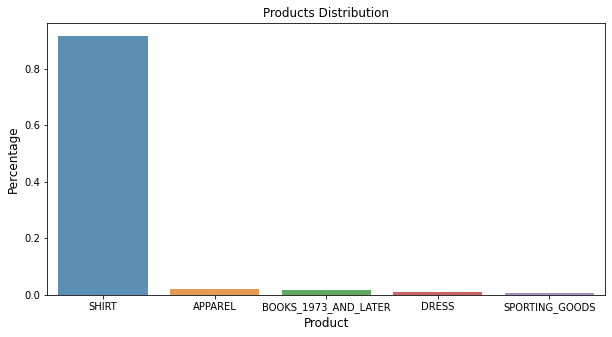

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
city_count  = data['product_type_name'].value_counts(normalize = True)[0:5]
#city_count = city_count[:5,]
plt.figure(figsize=(10,5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Products Distribution')
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.savefig("products distribution")
plt.show()

####  Color Feature details

In [10]:

data['color'].describe()

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

In [11]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

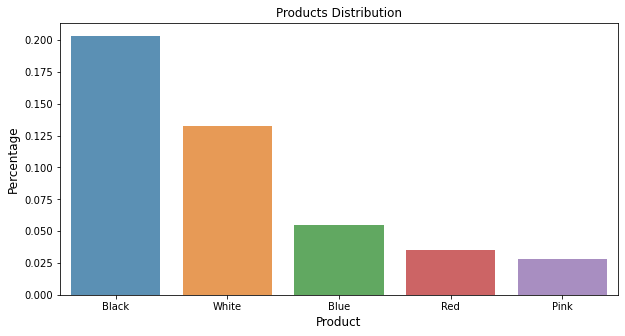

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
city_count  = data['color'].value_counts(normalize = True)[0:5]
#city_count = city_count[:5,]
plt.figure(figsize=(10,5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Products Distribution')
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.savefig("products distribution")
plt.show()

20% of the products have 'Black' color and approximately 14% have 'white' color

#### Formatted_price Feature details

In [13]:
print(data['formatted_price'].describe())


count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [14]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

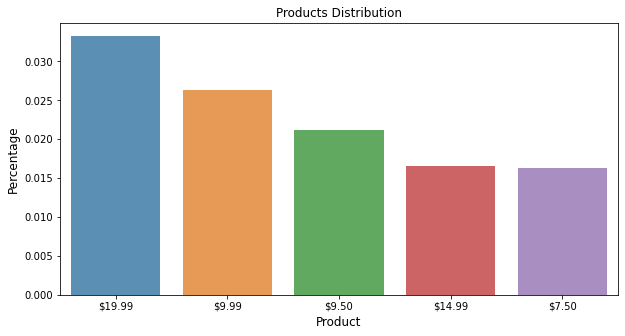

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
city_count  = data['formatted_price'].value_counts(normalize = True)[0:5]
#city_count = city_count[:5,]
plt.figure(figsize=(10,5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Products Distribution')
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.savefig("products distribution")
plt.show()

~ 35% products have USD 20 and 25% products have USD 10

#### Title Feature details

In [16]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


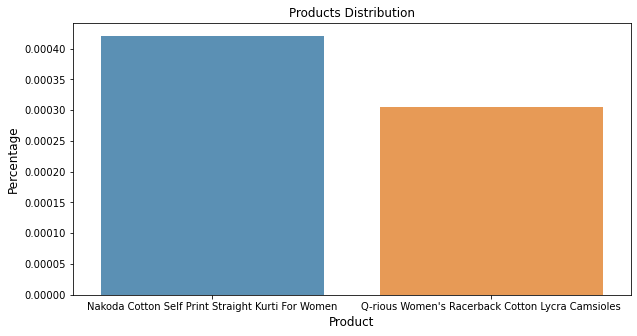

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
city_count  = data['title'].value_counts(normalize = True)[0:2]
#city_count = city_count[:5,]
plt.figure(figsize=(10,5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Products Distribution')
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.savefig("products distribution")
plt.show()

In [18]:
data.to_pickle('pickles/180k_apparel_data')

In [19]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price:', data.shape[0])

Number of data points After eliminating price: 28395


In [20]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color :', data.shape[0])

Number of data points After eliminating color : 28385


#### We brought down the number of data points from 183K  to 28K.


In [21]:
data.to_pickle('pickles/28k_apparel_data')

I have commented the below code as this code was used to download the images from my data and this code takes a while to run 

In [22]:
'''
from PIL import Image
import requests
from io import BytesIO

for index, row in images.iterrows():
        url = row['large_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/28k_images/'+row['asin']+'.jpeg')
'''        

"\nfrom PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index, row in images.iterrows():\n        url = row['large_image_url']\n        response = requests.get(url)\n        img = Image.open(BytesIO(response.content))\n        img.save('images/28k_images/'+row['asin']+'.jpeg')\n"

## Filtering Algorithm

If I just passed the initial dataset without any filtering - The first 10-15 recommendations were just duplicate values ( I will explain below what I mean by duplicate values). 

In [23]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickles/28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color

2325


**Scenario - A** : The shirts below are different products - they have unique product IDs. If we looked at the description- They are the same product in different sizes

<table>
<tr> 
<td><img src="dedupe/B00AQ4GMCK.jpeg",width=100,height=100> :B00AQ4GMCK</td>
<td><img src="dedupe/B00AQ4GMTS.jpeg",width=100,height=100> :B00AQ4GMTS</td>
</tr>
<tr> 
<td><img src="dedupe/B00AQ4GMLQ.jpeg",width=100,height=100> :B00AQ4GMLQ</td>
<td><img src="dedupe/B00AQ4GN3I.jpeg",width=100,height=100> :B00AQ4GN3I</td>
</tr>
</table>

**Scenario B -**  Completely duplicate titles.
* psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
* psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt


**Scenario C -**  Duplicate products in different colors.
<table>
<tr> 
<td><img src="dedupe/B00G278GZ6.jpeg",width=100,height=100> :B00G278GZ6</td>
<td><img src="dedupe/B00G278W6O.jpeg",width=100,height=100> :B00G278W6O</td>
</tr>
<tr> 
<td><img src="dedupe/B00G278Z2A.jpeg",width=100,height=100> :B00G278Z2A</td>
<td><img src="dedupe/B00G2786X8.jpeg",width=100,height=100> :B00G2786X8</td>
</tr>
</table>

Start to remove the duplicate items

In [24]:

data = pd.read_pickle('pickles/28k_apparel_data')

In [25]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [26]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)

In [27]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [28]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: 
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])
            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [29]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

#### Removed the duplicates which differ only at the end.

In [30]:
print('Number of data points : ', data.shape[0])# Now we have approximately 17K data points

Number of data points :  17593


In [31]:
data.to_pickle('pickles/17k_apperal_data')

As part of the logic below, I am removing titles whihc are adjacent and very similar. 
Example :
* 86261  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
* 115042UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

The products above differ in (Women and Ladies) + Color . 

In [32]:
data = pd.read_pickle('pickles/17k_apperal_data')

In [ ]:
# This code snippet takes significant amount of time.
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [ ]:
data.to_pickle('pickles/16k_apperal_data')

# Modeling 

In [ ]:
data = pd.read_pickle('pickels/16k_apperal_data')


In [ ]:
# we use the list of stop words from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [ ]:
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

In [ ]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

## Text based product similarity

In [ ]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')

The below functions will be re-used as I progress further 

In [ ]:
# Image Display function
def display_img(url,ax,fig):
    # Fetch URL of the product
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # Display the image in the notebook
    plt.imshow(img)
    
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # Setup the gridspace for the figure
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Call the display image function to display the image
        display_img(url, ax, fig)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary -> List of all words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary->List of all words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of words along with the frequency of each 
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}


def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Bag of Words (BoW) on product titles.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

In [ ]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(1000, 2)

## TF-IDF based product similarity

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])


In [ ]:
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(1000, 20)

# Keras and Tensorflow to extract features

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

The below code uses VGG-16 Neural Network to extract the image features. This code takes really long time (> 1 hour) to execute. Instead you can load the features directly to run the code below this cell

https://drive.google.com/drive/folders/1ZtheGzBjERU0BWPe92fwzyau2oYuMq89?usp=sharing

In [ ]:

# Code reference: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

#Do NOT run this code unless you want to wait a few hours for it to generate output

# each image is converted into 25088 length dense-vector

'''
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

'''

In [ ]:
import numpy as np 
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(1000, 20)